# Fashion-MNIST Classifier
**P2963116**

### Project Brief
1. Experience building and training Artificial Neural Networks (ANNs) for classification problems.
2. Experience preprocessing image datasets.
3. Experience implementing and testing neural networks in Python using PyTorch/TensorFlow.
4. Experience comparing different neural architectures (ANN vs. CNN).

The goal of this project is to create a working classifier for use on the Fashion-MNIST dataset and to compare different architectures' performance.
I will be using *PyTorch* primarily, but also *SciKit-Learn* and *MatPlotLib* to create my project and display output data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

sns.set_theme()

print("PyTorch version:", torch.__version__)
print("PyTorch working with CUDA:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu130
PyTorch working with CUDA: True


### Data import and pre-processing
Using Torchvision's datasets module we can easily import our dataset. It also comes with the built-in method 'transform' allowing us to preprocess our data. In this case we use the ToTensor method and Normalize to store the images correctly and normalise pixel values.

Additionally the DataLoader allows us to automatically batch and shuffle our training and test datasets should we wish. In this case we only really need to shuffle the training data as we will not be adjusting weights using the test dataset.

I have also added a couple of asserts to ensure our data was loaded correctly (through checking the shape). In this case there should be no issues.

In [2]:
# Ordered list of data labels as per Fashion MNIST Documentation
data_labels = [
    "T-Shirt",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
]

# Data pre-processing transformations
transforms = Compose([ToTensor(), Normalize(mean=0.5, std=0.5)])

# Initialise data
training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transforms
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transforms
)

# Train on 80%, reserve remainder for validation
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
train_subset, val_subset = random_split(training_data, [train_size, val_size])

# Batch Size (default = 64)
batch_size = 64

# Load the data with automatic shuffling for training/validation
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))
test_images, test_labels = next(iter(test_loader))

# Tests
train_expected_size = torch.Size([batch_size, 1, 28, 28])
assert train_images.shape == train_expected_size

val_expected_size = torch.Size([batch_size, 1, 28, 28])
assert val_images.shape == val_expected_size

expected_label_size = torch.Size([batch_size])
assert train_labels.shape == expected_label_size

### Example Image with label
Here we take the first image in one of our training batches and display using MatPlotLib, the title is its associated label.

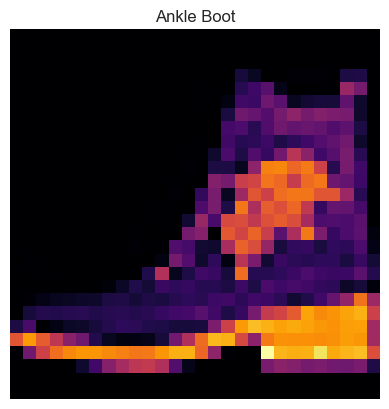

In [3]:
# Plot of random sample with label
img = train_images[0].squeeze()
label = data_labels[train_labels[0]]

fig = plt.imshow(img)
plt.axis("off")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.set_cmap("inferno")
plt.title(label)
plt.show()

## Building our ANN
Using PyTorch it is very easy to create a simple network using global variables and nn.Sequential, however using a class will give us some flexibility in the width of our model while allowing for non-destructive testing to occur while optimising our network architecture.
Furthermore, for the sake of comparison there exists 2 possible architectures within this class, one which contains dropout and another which does not. Initially, the linear model was tested using no dropout however as we will see below, we later implemented dropout to prevent overfitting from occuring during the training process.
Each class we create inherits from the nn.Module class and requires an init function as well as a forward function which defines the forward pass of the network.

### Init
In the init function we first inherit everything from nn.Module and then specify our ReLU stack. This is defined using a series of linear perceptrons and ReLU activation layers. In the  case of using dropout, we also add dropout layers into the sequence between each layer. Additionally we also specify a flatten method which enables us to input the raw tensor data directly from the DataLoader without having to store the flattened image tensors as a global variable.
For more information on the arguments see the comments in the code itself.

### Forward
This is very simple, it applies a forward pass to our model where we then apply Logarithmic Softmax to the output (as this is a classification task).

In [4]:
# Define a class for an MLP (dropout optional)
class MultilayerPerceptron(nn.Module):
    def __init__(self, hidden1, hidden2, hidden3, in_features=28 * 28, out_features=10, use_dropout=False, dropout_prob=0.2):
        """
        Multi-Layer Perceptron with specifiable hidden layer widths and optional use of dropout
        Args:
            hidden1 (int): specify the number of neurons in layer 1
            hidden2 (int): specify the number of neurons in layer 2
            hidden3 (int): specify the number of neurons in layer 3
            in_features (int/optional): specify the number of inputs (size of flattened image = length * width)
            out_features (int/optional): specify the number of outputs (number of classes)
            use_dropout (bool/optional): enable dropout
            dropout_prob (float/option): specify dropout probability. (default = 0.2)
        """
        super().__init__()
        self.flatten = nn.Flatten()
        if use_dropout:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features, hidden1),
                nn.BatchNorm1d(hidden1),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
                nn.Linear(hidden1, hidden2),
                nn.BatchNorm1d(hidden2),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
                nn.Linear(hidden2, hidden3),
                nn.BatchNorm1d(hidden3),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
                nn.Linear(hidden3, out_features),
            )
        else:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features, hidden1),
                nn.ReLU(),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Linear(hidden2, hidden3),
                nn.ReLU(),
                nn.Linear(hidden3, out_features),
            )

    def forward(self, x):
        x = self.flatten(x)
        output = self.lin_relu_stack(x)
        output = F.log_softmax(output, dim=1)
        return output

## CNN Architecture
Much the same as with the ANN, we create a class to define our CNN. This also inherits from nn.Module. Unlike the ANN, we do not need to flatten our input data until we have passed it through the convolution layers

### Init
Once again we inherit everything from the parent class nn.Module. Next we create a sequence of 2D-Convolution and MaxPool layers, a flatten method (identical to our ANN class) and a sequence of dense layers using ReLU as the activation functions.

### Forward
We define the forward pass by sending our input through the convolution stack before flattening this output. The flattened tensor is then, just as with the ANN sent through the dense layers before Log Softmax is applied and our output is returned.

In [5]:
# Define our CNN Architecture
class CNNNetwork(nn.Module):
    """
    Defines a simple Convolutional Neural Network with 2 convolution layers and 2 instances of MaxPooling. Dropout p=0.2 in the dense layers.
    Args:
    in_channels (int): number of input channels. 1 for greyscale, 3 for rgb images etc.
    out_channels (int): number of classes
    filters1 (int): number of filters in convolution block 1
    filters2 (int): number of filters in convolution block 2
    kernel1 (int/tuple): kernel size in conv block 1
    kernel2 (int/tuple): kernel size in conv block 2
    stride1 (int): stride for conv block 1
    stride2 (int): stride for conv block 2
    """
    def __init__(self, in_channels, out_channels, filters1, filters2, kernel1=3, kernel2=3, stride1=1, stride2=1):
        super().__init__()
        self.convstack = nn.Sequential(
            nn.Conv2d(in_channels, filters1, kernel1, stride1),
            nn.ReLU(),
            nn.Conv2d(filters1, filters1, kernel1, stride1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(filters1, filters2, kernel2, stride2),
            nn.ReLU(),
            nn.Conv2d(filters2, filters2, kernel2, stride2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(filters2 * 4 * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, out_channels),
        )

    def forward(self, x):
        output = self.convstack(x)
        output = self.flatten(output)
        output = self.dense(output)
        output = F.log_softmax(output, dim=1)
        return output

## Train/Test Functions
Since we are defining multiple models, it would be nice to just write the code to train and test once, hence we will use a function here instead of global variables.
### Train
This function outlines the training process in any given epoch. We first enable training mode using the train() method, calculate the muber of batches and set our total loss to 0 (for a specified criterion).
Now we iterate over all the items in our dataset using a for loop.
We zero the gradient calculations before performing a forward pass of our model and calculating the loss. We then backpropagate using the backward() method and use the step() method to update the training parameters based on our optimiser. We finally add the training loss for every item before calculating the mean loss per batch. 
This value is then printed and returned.
### Test
Similar to the train function, however we need not specify an optimiser as we will not be updating any weights.
The eval() method sets our model to evaluation mode, meaning parameters will not be updated as we iterate over the data. Since we are going to be recording accuracy we need both the number of batches and number of samples for our given dataloader. 
We perform the forward pass of our model with no gradients calculated but this time we also want to check if the prediction is correct so we may calculate the accuracy of the model.

In [6]:
# Define a train and test function for use with our models
def train(dataloader, model, loss_fn, optimizer):
    """
    Perform a simple training pass for one epoch
    Args:
        dataloader (Dataloader(data)): Dataloader using torchvision
        model (ANN/CNN): Chosen model
        loss_fn: Loss function used
        optimizer: optimiser used for gradient parameter adjustment
    Returns:
    train_loss (float): Average loss over the whole training set
    """
    model.train()
    num_batch = len(dataloader)
    train_loss = 0.0
    for X, label in dataloader:
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batch
    return train_loss


def test(dataloader, model, loss_fn):
    """
    Perform a test pass.
    Args:
        dataloader (DataLoader(data)): Dataloader of a dataset using torchvision
        model (ANN/CNN): Chosen model
        loss_fn: Loss function
    Returns:
    test_loss (float): Average loss on validation set
    accuracy (float): Accuracy on validation set
    """
    model.eval()
    num_batch = len(dataloader)
    samples = len(dataloader.dataset)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, label in dataloader:
            pred = model(X)
            loss = loss_fn(pred, label)
            test_loss += loss.item()
            pred = pred.argmax(1)
            correct += (pred == label).type(torch.float).sum().item()
    test_loss /= num_batch
    accuracy = correct / samples * 100
    return test_loss, accuracy

## Combining train and test
Finally, we want to call a single function which can iterate our training and test datasets over a specified number of epochs. To track our losses and accuracy we store these values in a list where each item in loss_hist is itself a list containing the training loss and the test loss, while accuracy_hist only contains the accuracy of the model on the test dataset.
These lists are returned for use in plotting.

In [7]:
# Train/test loop combined, we will use accuracy as our primary metric
def run(train_loader, val_loader, test_loader, model, epochs, loss_fn, optimizer):
    """
    Runs our model train and test loop for a specified number of epochs
    Args:
    train_loader (Dataloader(data)): Training data
    val_loader (Dataloader(data)): Validation data
    test_loader (Dataloader(data)): Test data
    model (MultilayerPerceptron): Model
    epochs (int): Number of epochs
    Returns:
    history (dict): Dictionary with keys, epochs, train_loss, val_loss, accuracy_hist. Values are lists of length range(epochs)
    test_accuracy (float): Accuracy on test loader
    """
    train_loss_hist = []
    val_loss_hist = []
    accuracy_hist = []

    for e in range(epochs):
        print(f"Epoch {e + 1}/{epochs}")
        train_loss = train(train_loader, model, loss_fn, optimizer)
        print(f"Training loss = {train_loss:>5f}")
        val_loss, val_accuracy = test(val_loader, model, loss_fn)
        print(f"Validation loss = {val_loss:>5f} (Accuracy = {val_accuracy:.2f}%)")
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        accuracy_hist.append(val_accuracy)

    # Return test acc for final epoch
    print("Switching to test set:")
    _, test_accuracy = test(test_loader, model, loss_fn)
    print(f"Final accuracy on test set: {test_accuracy:.2f}%")
    history = {
        "epoch": range(epochs),
        "train_loss": train_loss_hist,
        "val_loss": val_loss_hist,
        "accuracy_hist": accuracy_hist,
    }
    return history, test_accuracy

In [8]:
def PrepareData(result):
    """
    Takes our outputs from run and prepares it for plotting.
    Calculates a 3 epoch rolling average validation loss and 5 epoch rolling average validation accuracy
    Args:
    result (dict): Dictionary output from run function
    Returns:
    data (pd.DataFrame): Pandas dataframe for use with seaborn
    """
    data = pd.DataFrame(result)
    data["val_rolling"] = data.val_loss.rolling(3).mean()
    data["acc_rolling"] = data.accuracy_hist.rolling(5).mean()
    return data

## Confusion matrix
In addition, it is nice to visualise the confusion matrix for our models so we can easily identify potential shortcomings of our model, and also debug any potential issues. For example, I was consistently facing an issue where my model was unable to produce any predictions for index 6: "Shirt", caused by a bottleneck in network width. Without the use of the visualisation it was difficult to understand why my model had limited accuracy. As such visualising the results like this was very impactful in diagnosing issues with my models.

In [9]:
# Confusion matrix plotter
def ConfMatDisplay(dataloader, model):
    """
    Create a confusion matrix and plot
    Args:
        dataloader (Dataloader(data)): Option to use a custom dataloader for test data
        model (ANN/CNN): Model
    """
    predictions = []
    labels = []
    for data, label in dataloader:
        pred = model(data)
        pred = pred.argmax(1)
        predictions += pred.tolist()
        labels += label.tolist()
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(cm, display_labels=data_labels)
    disp.plot(xticks_rotation="vertical", cmap="inferno")
    plt.grid(False)
    plt.show()

## The first model
Initially I had opted to use layer widths of 512,256,128 (as was used in the lab material), but as mentioned above, it led to issues with the model being unable to predict an entire category of label. Upon changing to values which are divisors of our input lengths (392,196,98), the performance of the model jumped with an increase in accuracy of around 10%. This did increase the overall number of training parameters increasing the training time however it caused a very noticable increase in performance. There is still a potential bottleneck in the output layer as we go from 98 inputs to just 10 outputs so further testing may show that a narrower model (or an addition layer with fewer neurons) will increase performance.
### Hyperparameters
To start we will use the fairly standard value of 0.001 as our learn rate and I decided on 30 epochs for training as this would mean the model takes around 5 minutes to exectute a full train/test loop with my RTX 3070ti. It also means there is plenty of time to observe potential problems such as overfitting and underfitting when plotting the results of training.
### Loss function and Optimiser Choice
Initially, We will be using Negative Log Likelihood as our loss function and Adam as our optimiser. We can also use Stochastic Gradient Descent (SGD), another good choice for classifier tasks and something we will see used in the comparison graphs below.
The benefits of Adam over SGD are that the algorithm allows for variable learning rates which may enhance convergence speed reducing the number of epochs required to optimally train the model.

In [10]:
# Initialise ANN and show structure
ann_model = MultilayerPerceptron(392, 196, 98)
print(ann_model)

# Hyperparameters
learn_rate = 1e-3
epochs = 30

# initialise loss function and optimiser
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(ann_model.parameters(), lr=learn_rate)

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=98, bias=True)
    (5): ReLU()
    (6): Linear(in_features=98, out_features=10, bias=True)
  )
)


In [ ]:
# Train and test the model based on hyperparameters
ann_hist, ann_test_accuracy = run(train_loader, val_loader, test_loader, ann_model, epochs, loss_fn, optimizer)

Epoch 1/30
Training loss = 0.529260
Validation loss = 0.425090 (Accuracy = 84.25%)
Epoch 2/30
Training loss = 0.384071
Validation loss = 0.396832 (Accuracy = 85.28%)
Epoch 3/30
Training loss = 0.341610
Validation loss = 0.367669 (Accuracy = 86.58%)
Epoch 4/30
Training loss = 0.316517
Validation loss = 0.355786 (Accuracy = 87.18%)
Epoch 5/30
Training loss = 0.300388
Validation loss = 0.337537 (Accuracy = 87.75%)
Epoch 6/30
Training loss = 0.276552
Validation loss = 0.350344 (Accuracy = 87.62%)
Epoch 7/30
Training loss = 0.261647
Validation loss = 0.341588 (Accuracy = 87.73%)
Epoch 8/30
Training loss = 0.252241
Validation loss = 0.332372 (Accuracy = 87.86%)
Epoch 9/30
Training loss = 0.238981
Validation loss = 0.332454 (Accuracy = 88.62%)
Epoch 10/30
Training loss = 0.225185
Validation loss = 0.315729 (Accuracy = 89.08%)
Epoch 11/30
Training loss = 0.217565
Validation loss = 0.343200 (Accuracy = 88.31%)
Epoch 12/30
Training loss = 0.208783
Validation loss = 0.340296 (Accuracy = 88.08%)
E

### Plotting Losses
From the above output it may be useful to visualise the loss over time of our model to diagnose any potential issues. As we will see below, we see some significant overfitting occur as the validation loss begins to diverge after around 10 epochs. We will work to mitigate this in a number of ways as discussed below.

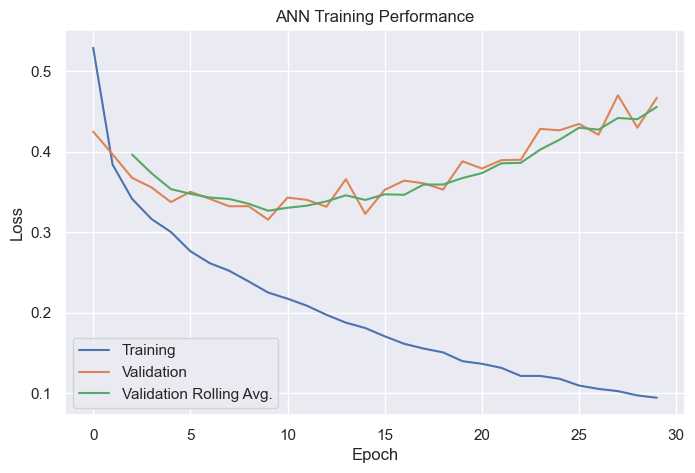

In [12]:
ann_data = PrepareData(ann_hist)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=ann_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(data=ann_data, x="epoch", y="val_loss", label="Validation")
sns.lineplot(data=ann_data, x="epoch", y="val_rolling", label="Validation Rolling Avg.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ANN Training Performance")
plt.show()

### Confusion Matrix
What we can see here is there is a number of areas where the model fails to correctly classify the image. Intuitively this might make sense as the common erros are between categories such as 'Shirt', 'Tshirt', 'Coat' and 'Pullover,' which when considering the size of our input images  seems like a reasonable error that even a human might make.

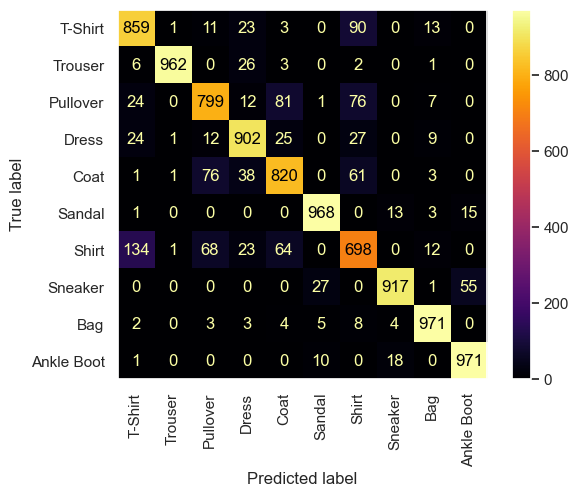

In [13]:
# Visualise confusion matrix for our first model
ConfMatDisplay(test_loader, ann_model)

## Mitigating Overfitting
As we see in the data above, there is a significant amount of overfitting that occured during the training process. There is a number of ways we can deal with this, which we will implement in due course.
### Dropout
Dropout involves randomly disabling connections between layers at a fixed probability, in this case we will use p=0.2. Note that this only occurs during training as when we apply the model.eval() method, it disables dropout layers. The goal of this is to try and prevent the model from overoptimising on the training dataset, limiting its ability to predict unseen data accurately.
### Batch Normalisation
A further method we can use is through Batch Normalisation (BatchNorm). This aims to improve the stability of training by normalising each batch of input data, essentially performing a rescaling of inputs, much the same as we did by normalising the images when preprocessing our data.
## Modified Model
Considering the above, we will reinitalise a new model with the above two ideas implemented. For the sake of comparison all the other aspects are equal.

In [14]:
# Define a new ANN with dropout for comparison
ann_dropout = MultilayerPerceptron(392, 196, 98, use_dropout=True)
print(ann_dropout)
dropout_optimizer = torch.optim.Adam(ann_dropout.parameters(), lr=learn_rate)

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=392, out_features=196, bias=True)
    (5): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=196, out_features=98, bias=True)
    (9): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=98, out_features=10, bias=True)
  )
)


In [15]:
# Train and test
dropout_hist, dropout_test_accuracy = run(train_loader,val_loader,test_loader,ann_dropout,epochs,loss_fn,dropout_optimizer)

Epoch 1/30
Training loss = 0.541638
Validation loss = 0.427950 (Accuracy = 84.39%)
Epoch 2/30
Training loss = 0.403687
Validation loss = 0.354366 (Accuracy = 86.87%)
Epoch 3/30
Training loss = 0.363605
Validation loss = 0.336604 (Accuracy = 87.30%)
Epoch 4/30
Training loss = 0.344020
Validation loss = 0.329850 (Accuracy = 87.87%)
Epoch 5/30
Training loss = 0.322957
Validation loss = 0.313182 (Accuracy = 88.64%)
Epoch 6/30
Training loss = 0.304840
Validation loss = 0.305661 (Accuracy = 89.04%)
Epoch 7/30
Training loss = 0.294001
Validation loss = 0.299815 (Accuracy = 88.94%)
Epoch 8/30
Training loss = 0.283571
Validation loss = 0.296348 (Accuracy = 89.11%)
Epoch 9/30
Training loss = 0.268727
Validation loss = 0.297432 (Accuracy = 88.83%)
Epoch 10/30
Training loss = 0.260846
Validation loss = 0.323988 (Accuracy = 88.42%)
Epoch 11/30
Training loss = 0.254648
Validation loss = 0.292714 (Accuracy = 89.37%)
Epoch 12/30
Training loss = 0.243534
Validation loss = 0.290832 (Accuracy = 89.60%)
E

What we immediately notice from the outputs of our train/test functions is the loss values are much closer together and we only begin to see the impact of overfitting towards later epochs. What this does fully mitigate is the loss on the validation set diverging entirely so the model no longer becomes more incorrect with further training (at least  from our chosen epoch count). We can see a clear visual representation of this in the plot below:
### Early Stopping
What we might see now, especially as the validation loss essentially flatlines after around 15 epochs is that it might be beneficial to implement early stopping since the model doesn't noticably improve in performance on unseen data beyond this point.

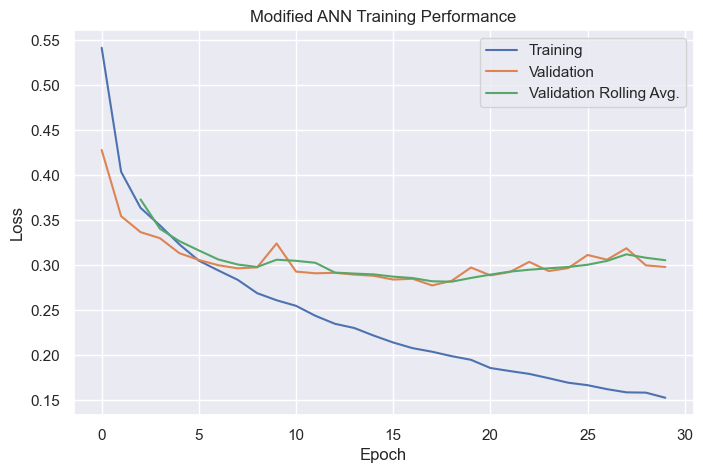

In [16]:
dropout_data = PrepareData(dropout_hist)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=dropout_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(data=dropout_data, x="epoch", y="val_loss", label="Validation")
sns.lineplot(data=dropout_data, x="epoch", y="val_rolling", label="Validation Rolling Avg.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Modified ANN Training Performance")
plt.show()

### Confusion Matrix
We can see here a clear impact on the precision of our model as there is a more even spread of incorrect results. There is nearly a 10 percentage point improvement in performance in how well the model classifies shirts correctly for example. 
Interestingly we do observe that the model might be less precise in this configuration (at least without early stopping implemented) with a lower score  in the 'Shirt' Category.

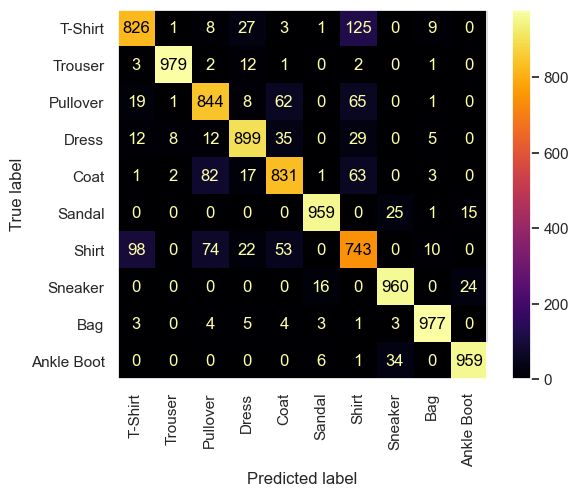

In [17]:
# Visualise confusion matrix
ConfMatDisplay(test_loader, ann_dropout)

## CNN Architecture
We now implement our CNN, this will consist of 4 convolutional layers, 2 max pooling layers, then a set of 3 dense layers that occur after flattening the image tensor.
Note that we apply our findings from above to add Batch Norm and Dropout layers in the dense part of our network. We use the same optimiser and final activation function as this seems to have worked well thusfar with few issues.

In [18]:
# Initialise with hyperparameters
cnn = CNNNetwork(in_channels=1, out_channels=10, filters1=32, filters2=64)
print(cnn)
cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr=learn_rate)

CNNNetwork(
  (convstack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8):

In [19]:
# Train and test
cnn_hist, cnn_taccuracy = run(train_loader, val_loader, test_loader, cnn, epochs, loss_fn, cnn_optimizer)

Epoch 1/30
Training loss = 0.613745
Validation loss = 0.337272 (Accuracy = 87.60%)
Epoch 2/30
Training loss = 0.368061
Validation loss = 0.283347 (Accuracy = 89.74%)
Epoch 3/30
Training loss = 0.310728
Validation loss = 0.250496 (Accuracy = 91.02%)
Epoch 4/30
Training loss = 0.274630
Validation loss = 0.267823 (Accuracy = 90.36%)
Epoch 5/30
Training loss = 0.257377
Validation loss = 0.254563 (Accuracy = 90.97%)
Epoch 6/30
Training loss = 0.236237
Validation loss = 0.237934 (Accuracy = 91.53%)
Epoch 7/30
Training loss = 0.218697
Validation loss = 0.217426 (Accuracy = 91.99%)
Epoch 8/30
Training loss = 0.203442
Validation loss = 0.225425 (Accuracy = 92.03%)
Epoch 9/30
Training loss = 0.192934
Validation loss = 0.223892 (Accuracy = 91.65%)
Epoch 10/30
Training loss = 0.181185
Validation loss = 0.224207 (Accuracy = 92.13%)
Epoch 11/30
Training loss = 0.170120
Validation loss = 0.232415 (Accuracy = 92.11%)
Epoch 12/30
Training loss = 0.160957
Validation loss = 0.220872 (Accuracy = 92.35%)
E

### Loss evaluation and performance
What is immediately obvious is that a CNN performs better than the ANNs as we are easily able to pass the 90% accuracy breakpoint. However, there is some evidence of overfitting occuring, likely due to a lack of dropout between the convolution layers. As such it may be wise to stop training after around 10 to 15 epochs as the model is likely to perform even better on unseen data after that point.

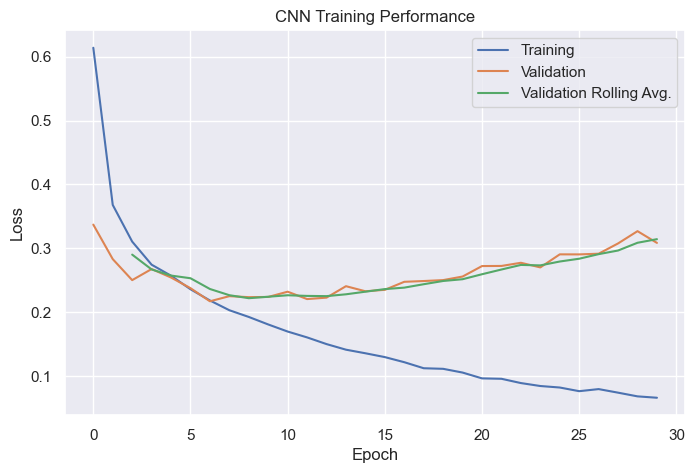

In [20]:
cnn_data = PrepareData(cnn_hist)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=cnn_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(data=cnn_data, x="epoch", y="val_loss", label="Validation")
sns.lineplot(data=cnn_data, x="epoch", y="val_rolling", label="Validation Rolling Avg.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training Performance")
plt.show()

### Confusion Matrix
We can see the CNN is the best perfomer so far, especially with regards to the problematic classification of shirts. There is a clear improvement in precision where we once again see an uplift in the minimum number of correct predictions. This is likely due to a CNN's ability to better store spatial information (by virtue of the structure of a matrix).

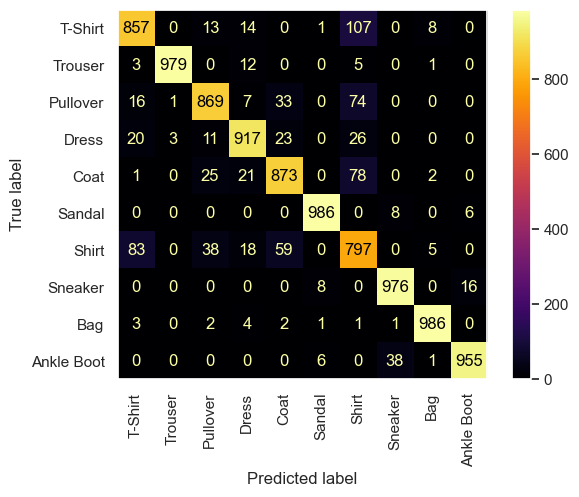

In [21]:
# Visualise confusion matrix
ConfMatDisplay(test_loader, cnn)

### Comparing Model Accuracy
Below is a plot of the models' performance on the validation set in training. I note that there is only a small bump in accuracy when implementing dropout and batch norm in spite of how noticable the improvements to training stability are.

The CNN is very clearly the 'winner' when it comes to classifying test data correctly, scoring 3-4% better than both the ANN models. Additionally it reaches this point much faster than the ANNs, taking only around 10 epochs to peak in validation accuracy.

The accuracy plot shows quite clearly where overfitting begins to take place as if we were to plot a moving average we would see the gradient starts to reduce and in the case of the CNN and original ANN, become negative.

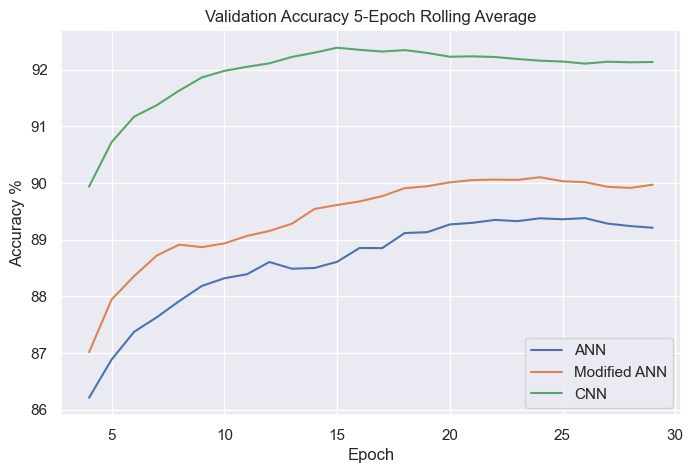

In [22]:
# Comparitive validation accuracy plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=ann_data, x="epoch", y="acc_rolling", label="ANN")
sns.lineplot(data=dropout_data, x="epoch", y="acc_rolling", label="Modified ANN")
sns.lineplot(data=cnn_data, x="epoch", y="acc_rolling", label="CNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Validation Accuracy 5-Epoch Rolling Average")
plt.show()

### Test Set Accuracy Comparison

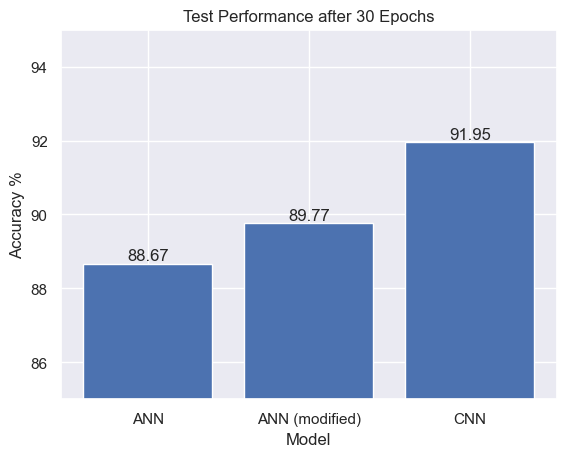

In [23]:
# Test performance comparison
x = ["ANN", "ANN (modified)", "CNN"]
accuracy_data = [ann_test_accuracy, dropout_test_accuracy, cnn_taccuracy]
barchart = plt.bar(x, accuracy_data)
plt.bar_label(barchart, fmt="{:.2f}")
plt.ylim(85, 95)
plt.xlabel("Model")
plt.ylabel("Accuracy %")
plt.title(f"Test Performance after {epochs} Epochs")
plt.show()

## Optimiser Choice
We have used Adam for all of our models thusfar, however for the sake of comparison let us compare the impact of different optimisers on model performance. We will now create a copy of our existing modified ANN model (since training will take less time), but this time use SGD with momentum set to 0.9.

In [24]:
ann_SGD = MultilayerPerceptron(392, 196, 98, use_dropout=True)
SGD_optimizer = torch.optim.SGD(ann_SGD.parameters(), lr=learn_rate, momentum=0.9)

In [25]:
# Train and test
SGD_hist, SGD_test_accuracy = run(train_loader, val_loader, test_loader, ann_SGD, epochs, loss_fn, SGD_optimizer)

Epoch 1/30
Training loss = 0.829498
Validation loss = 0.474881 (Accuracy = 83.42%)
Epoch 2/30
Training loss = 0.500216
Validation loss = 0.400210 (Accuracy = 85.78%)
Epoch 3/30
Training loss = 0.440315
Validation loss = 0.369695 (Accuracy = 86.60%)
Epoch 4/30
Training loss = 0.409593
Validation loss = 0.359119 (Accuracy = 87.14%)
Epoch 5/30
Training loss = 0.387055
Validation loss = 0.344292 (Accuracy = 87.64%)
Epoch 6/30
Training loss = 0.368326
Validation loss = 0.334264 (Accuracy = 87.89%)
Epoch 7/30
Training loss = 0.351902
Validation loss = 0.347949 (Accuracy = 87.38%)
Epoch 8/30
Training loss = 0.341167
Validation loss = 0.321588 (Accuracy = 88.45%)
Epoch 9/30
Training loss = 0.331827
Validation loss = 0.309840 (Accuracy = 88.96%)
Epoch 10/30
Training loss = 0.318727
Validation loss = 0.305214 (Accuracy = 88.98%)
Epoch 11/30
Training loss = 0.310213
Validation loss = 0.303720 (Accuracy = 88.89%)
Epoch 12/30
Training loss = 0.306751
Validation loss = 0.297267 (Accuracy = 89.19%)
E

### Observations
Immediate observations suggest that Adam produces generally lower loss, especially on the training sets suggesting it could be 'better' than SGD. The potential issue is that Adam produces much noisier training results which could lead to later issues. Of course we must bare in mind that since elements of training cycles are randomised that we will not produce the exact same results each time we train the models so a single round of 30 epochs is potentially an unreliable metric to work from. The main takeaway here is that both seem to provide an effective means of optimising our model parameters, especially as both models predict to a very similar accuracy on the test set following training. 

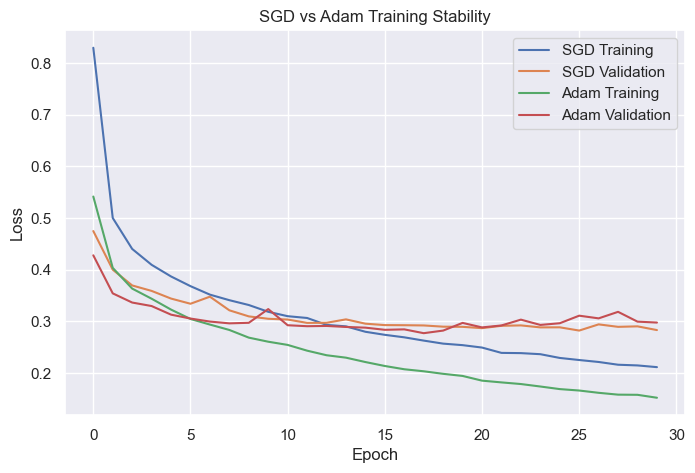

In [26]:
# Prepare data
sgd_data = PrepareData(SGD_hist)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=sgd_data, x="epoch", y="train_loss", label="SGD Training")
sns.lineplot(data=sgd_data, x="epoch", y="val_loss", label="SGD Validation")
sns.lineplot(data=dropout_data, x="epoch", y="train_loss", label="Adam Training")
sns.lineplot(data=dropout_data, x="epoch", y="val_loss", label="Adam Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SGD vs Adam Training Stability")
plt.show()

## Closing Thoughts
